# Logarithm

Here we analyse how accurate are the approximate functions for Logarithm

We compare two methods:
- Newton Raphson
- 6th order HouseHolder

We show how they perform in the context of encrypted computation, show that 6th order HouseHolder is better suited and discuss how to improve initialization of this method.

### Define a benchmark method

In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [2]:
import torch as th
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def benchmark(real_func, approx_func, interval, n_points=100, approx_kwargs={}, forward_transformer=lambda x:x, backward_transformer=lambda x:x):
    """
    Benchmark an approximation function compared to an exact function.
    Compute and print the relative divergence
    
    Args:
        real_func: 
        approx_func: 
        interval: 
        n_points: 
        approx_kwargs: optional kwargs to provide to the approximation function
        forward_transformer: optional input transformation to apply before calling approx_func
        backward_transformer: optional output transformation to apply after calling approx_func
    """
    start, stop = interval
    points = np.linspace(start, stop, num=n_points)
    real_values = []
    approx_values = []
    for x in points:
        x = th.tensor([x])
        real_value = real_func(x)
        real_values.append(real_value.item())
        x_syft = forward_transformer(x)
        approx_value_syft = approx_func(x_syft, **approx_kwargs)
        approx_value = backward_transformer(approx_value_syft)
        approx_values.append(approx_value.item())
        
    plt.figure(figsize=(15,4))
    plt.subplot(121, title="Real and approximate logarithm")
    real_values = np.array(real_values)
    approx_values = np.array(approx_values)
    plt.plot(points, real_values)
    plt.plot(points, approx_values)
    
    plt.subplot(122, title="Relative error")
    norm_diff = 2 * np.abs(real_values - approx_values)/np.abs(real_values + approx_values)
    plt.plot(points, norm_diff)

    plt.show()

## 1. Using the Newton Raphson method

In [4]:
from funcs import log_newton, log_householder

## 1.A Approximation alone

We analyse here the loss incurred by the approximation using only normal pytorch tensors

In [5]:
if not hasattr(th, 'native_exp'):
    th.native_exp = th.exp
    
    def hook_exp(x, **kwargs):
        return th.native_exp(x)

    th.exp = hook_exp
    th.Tensor.refresh = lambda x:x

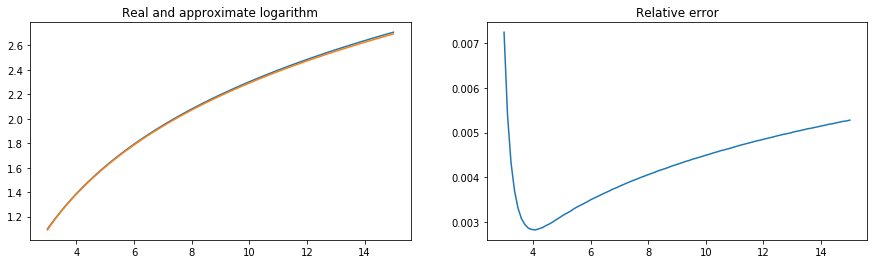

In [6]:
benchmark(
    th.log, 
    log_newton,
    interval = (3, 15), 
    approx_kwargs={'iterations': 3}
)

This is great but it is limited to a small interval $[3, 5]$. On a full range interval $[0.1, 250]$ it behaves poorly. We show here the result with different number of iterations.

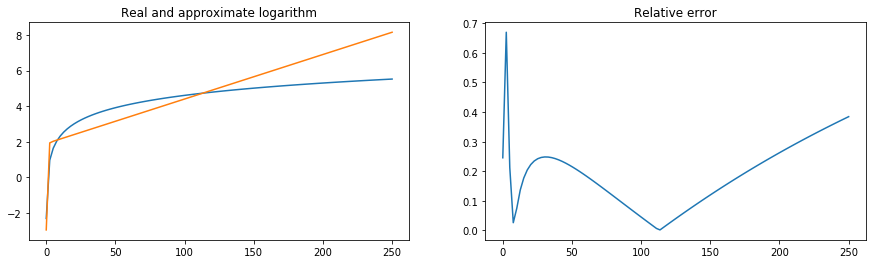

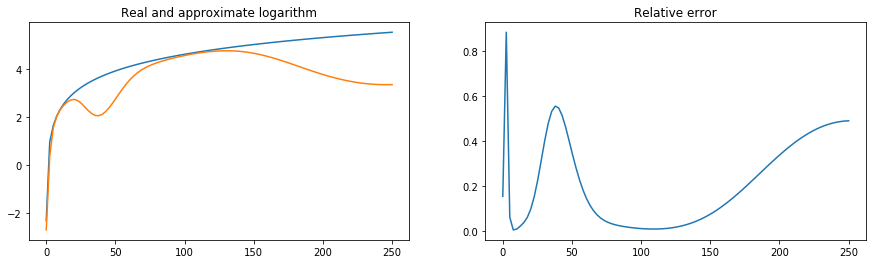

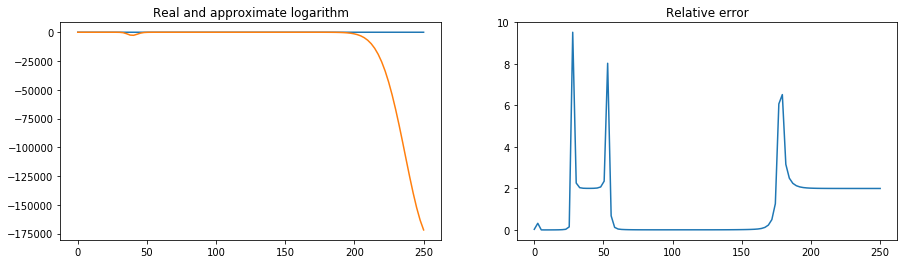

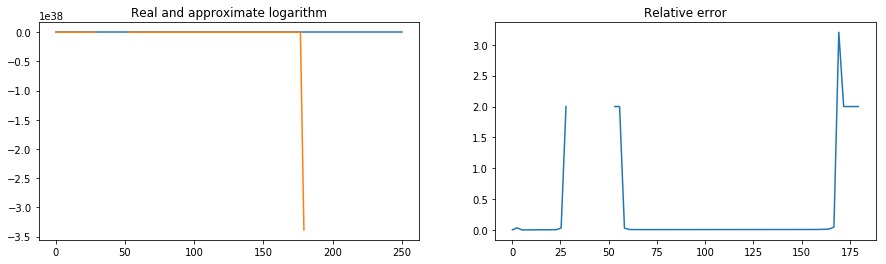

In [7]:
for it in [0, 1, 2, 3]:
    benchmark(
        th.log, 
        log_newton,
        interval = (0.1, 250), 
        approx_kwargs={'iterations': it}
    )

## 1.B Approximation with AdditiveSharingTensors

In [8]:
import syft as sy
hook = sy.TorchHook(th)

bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
charlie = sy.VirtualWorker(hook, id="charlie")
crypto = sy.VirtualWorker(hook, id="crypto_provider")

In [9]:
th.Tensor.native_refresh = th.Tensor.refresh

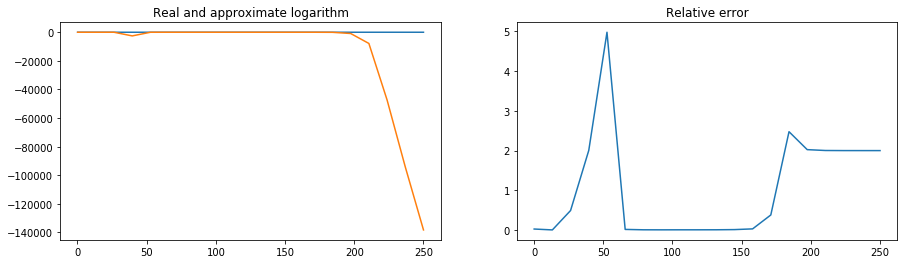

In [10]:
benchmark(
    th.log, 
    log_newton, 
    interval = (0.1, 250), 
    n_points=20,
    approx_kwargs={'iterations': 2, 'exp_iterations': 8},
    forward_transformer=lambda x: x.fix_precision(precision_fractional=5).share(alice, bob, crypto_provider=crypto),
    backward_transformer=lambda x: x.get().float_precision()
)

Interestingly here, the approximation only works on a given range, roughly $[70:160]$ 

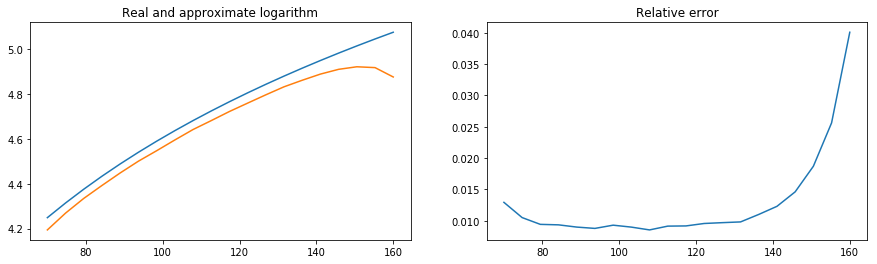

In [11]:
benchmark(
    th.log, 
    log_newton, 
    interval = (70, 160), 
    n_points=20,
    approx_kwargs={'iterations': 2, 'exp_iterations': 8},
    forward_transformer=lambda x: x.fix_precision(precision_fractional=5).share(alice, bob, crypto_provider=crypto),
    backward_transformer=lambda x: x.get().float_precision()
)

With more iterations $2 \rightarrow 8$, results are a bit better but are much more expensive to compute:

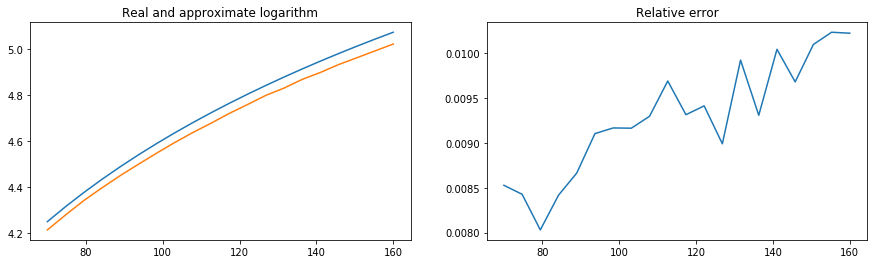

In [12]:
benchmark(
    th.log, 
    log_newton, 
    interval = (70, 160), 
    n_points=20,
    approx_kwargs={'iterations': 8, 'exp_iterations': 8},
    forward_transformer=lambda x: x.fix_precision(precision_fractional=5).share(alice, bob, crypto_provider=crypto),
    backward_transformer=lambda x: x.get().float_precision()
)

### Remarks
- The approximation and its range of validity depends on the initialization chosen

Here is an alternate initialization

In [13]:
from funcs import exp
def log_newton(x, iterations=2, exp_iterations=8):
    """Approximates the logarithm using the Newton Raphson method

    Args:
        iterations (int): number of iterations for Newton Raphson approximation.
        exp_iterations (int): number of iterations for limit approximation of exp

    .. inspired by https://github.com/facebookresearch/CrypTen
    """
    # PREVIOUS: 
    y = x / 40 + 1.9 - 8 * exp(-2 * x - 0.3, iterations=exp_iterations)
    # NEW:
    #y = x / 120 - 20 * exp(-2 * x - 1.0, iterations=exp_iterations) + 3.0

    for i in range(iterations):
        h = [1 - x * exp((-y).refresh(), iterations=exp_iterations)]
        for i in range(1, 5):
            h.append(h[-1] * h[0])

        y -= h[0] * (1 + h[0] + h[1] + h[2] + h[3] + h[4])

    return y

The field of validity is now very different!

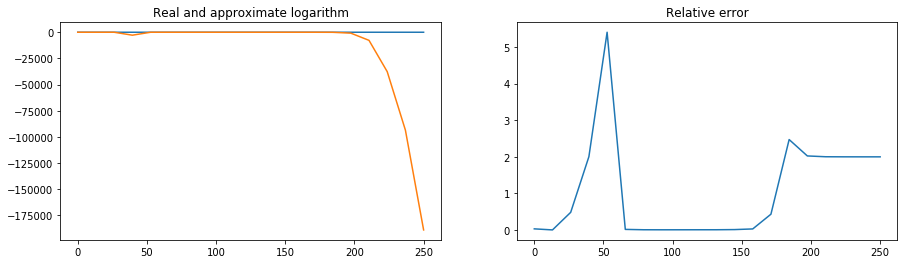

In [14]:
benchmark(
    th.log, 
    log_newton, 
    interval = (0.1, 250), 
    n_points=20,
    approx_kwargs={'iterations': 2, 'exp_iterations': 8},
    forward_transformer=lambda x: x.fix_precision(precision_fractional=5).share(alice, bob, crypto_provider=crypto),
    backward_transformer=lambda x: x.get().float_precision()
)

On $[5:23]$:

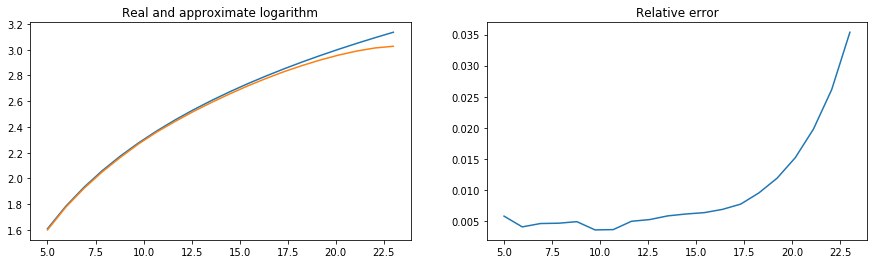

In [15]:
benchmark(
    th.log, 
    log_newton, 
    interval = (5, 23), 
    n_points=20,
    approx_kwargs={'iterations': 2, 'exp_iterations': 8},
    forward_transformer=lambda x: x.fix_precision(precision_fractional=5).share(alice, bob, crypto_provider=crypto),
    backward_transformer=lambda x: x.get().float_precision()
)

The reason for this is that Newton's method is really instable, in section 2 we study the HouseHolder method which is a better fit for this task.

# 2. Using the HouseHolder method

## 1.A Approximation alone

We analyse here the loss incurred by the approximation using only normal pytorch tensors

In [16]:
th.Tensor.refresh = lambda x:x

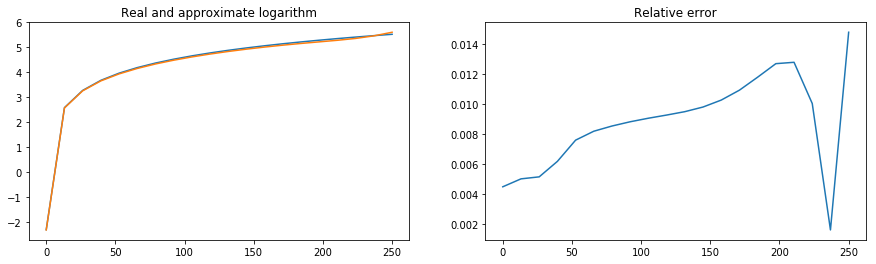

In [17]:
benchmark(
    th.log, 
    log_householder, 
    interval = (0.1, 250), 
    n_points=20,
    approx_kwargs={'iterations': 2, 'exp_iterations': 8}
)

Results are much better with this approximation, right?

What about adding AdditiveSharingTensors in the loop?

## 2.B Approximation with AdditiveSharingTensors

_We re-instantiate refresh as we work with AdditiveSharingTensors_

In [18]:
th.Tensor.refresh = th.Tensor.native_refresh

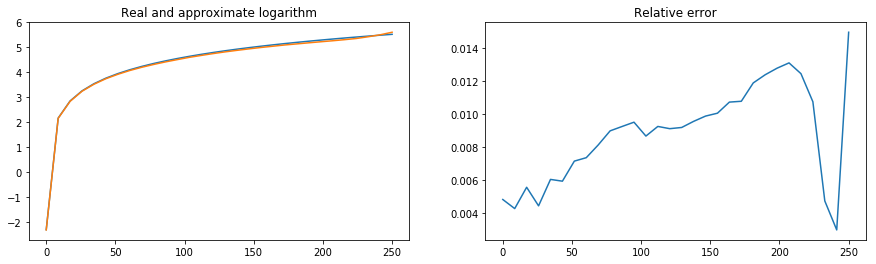

In [19]:
benchmark(
    th.log, 
    log_householder, 
    interval = (0.1, 250), 
    n_points=20,
    approx_kwargs={'iterations': 2, 'exp_iterations': 8},
    forward_transformer=lambda x: x.fix_precision(precision_fractional=5).share(alice, bob, crypto_provider=crypto),
    backward_transformer=lambda x: x.get().float_precision()
)

This is still very good!

One interesting quesiton is now to see how the initialisation provided influence the global approximation. We'll investigate in the following part how to find the best initialisation.

# 3. Optimisation of the initialisation

In [20]:
import torch as th
import torch.nn as nn
from funcs import exp_limit

In [21]:
class ApproxModel(nn.Module):
    def __init__(self):
        super(ApproxModel, self).__init__()
        self.w1 = nn.Parameter(th.tensor(1/120.))
        self.b1 = nn.Parameter(th.tensor(3.))
        
        self.alpha = nn.Parameter(th.tensor(-20.))
        
        self.w2 = nn.Parameter(th.tensor(-2.))
        self.b2 = nn.Parameter(th.tensor(-1.))
        
    def forward(self, x):
        
        y = x * self.w1 + self.b1 + self.alpha * exp_limit(x * self.w2 + self.b2)
    
        for i in range(2):
            h = [1 - x * exp_limit(-y)]
            for i in range(1, 5):
                h.append(h[-1] * h[0])

            y -= h[0] * (1 + h[0] / 2 + h[1] / 3 + h[2] / 4 + h[3] / 5 + h[4] / 6)
            
        return y

In [22]:
# Training settings
model = ApproxModel()
optimizer = th.optim.Adam(params=model.parameters(), lr=0.001)
n_points = 1000
batch_size = 100

# 1. Built the training set
# np.logspace(-3, 2.4) is a range from 0.001 to 250
data = th.tensor(np.logspace(-3, 2.4, num=n_points))
# permute data and reshape
data = data[th.randperm(n_points)].view(-1, 1)

# 2. compute the target
target = th.log(data)

In [23]:
for epoch in range(10000):
    # randomly shuffle at each epoch
    rand_idx = th.randperm(n_points)
    for i in range(int(n_points/batch_size)):
        if i == 1 and epoch % 100 == 0:
            print(
                round(1/model.w1.item(), 2), 
                round(model.b1.item(), 2), 
                round(model.alpha.item(), 2), 
                round(model.w2.item(), 2), 
                round(model.b2.item(), 2),
                loss.item()
            )
        data_batch = data[rand_idx[i:i+batch_size]]
        target_batch = target[rand_idx[i:i+batch_size]]
        
        optimizer.zero_grad()
        pred = model(data)
        # the loss chosen is a normalized MSE
        loss = (((pred - target)/(pred + target))**2).mean()
        loss.backward()
        optimizer.step()
        

136.36 3.0 -20.0 -2.0 -1.0 0.0010121791163840014
73.7 3.0 -19.8 -1.37 -1.2 0.0010092084533676426
68.97 2.99 -19.8 -1.06 -1.2 0.0010091825463284811
67.68 2.98 -19.8 -0.77 -1.2 0.0010091690151020996
67.46 2.98 -19.8 -0.76 -1.2 0.0010091687172309864
67.25 2.97 -19.8 -0.76 -1.21 0.001009168310990304
66.91 2.95 -19.79 -0.77 -1.21 0.0010091676981853826
66.39 2.92 -19.79 -0.78 -1.21 0.0010091668218822015
65.67 2.89 -19.79 -0.8 -1.22 0.001009165653755806
64.69 2.83 -19.79 -0.83 -1.23 0.0010091642026754189
63.49 2.76 -19.78 -0.9 -1.24 0.0010091623065309236
22.43 2.66 -19.78 -1.01 -1.26 0.0017678908163577952
22.43 2.66 -19.78 -0.92 -1.26 0.0017659120828783176
22.45 2.66 -19.78 -0.92 -1.26 0.0017626352876977834
22.47 2.66 -19.78 -0.92 -1.26 0.0017572903098240673
22.51 2.66 -19.78 -0.92 -1.26 0.0017485672781550386
22.57 2.66 -19.78 -0.92 -1.26 0.001734407011235761
22.66 2.66 -19.78 -0.93 -1.26 0.0017115915974744646
22.82 2.66 -19.78 -0.93 -1.26 0.0016756662593725594
23.08 2.66 -19.78 -0.93 -1.26 0

The params seem to be converging, we will keep those one for our implementation. Note that the relative error is very small and is close to 10e-3.